# ***Loading Libraries And Dataset***

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Constants
c = 3e8  # Speed of light in m/s
substrate_efficiency = {'FR4': 0.6, 'PTFE': 0.8, 'CERAMIC': 0.9}  # Efficiency based on material
feed_position_gain = {'Center': 1.1, 'Edge': 0.9}  # Gain multiplier based on feed position

# Load prepared dataset
data = pd.read_csv('/content/drive/MyDrive/updated_realistic_antenna_dataset.csv')

#***Function To Calculate Gain***

In [4]:
# Function to calculate gain
def calculate_gain(length, width, height, frequency, substrate, feed_position, bandwidth, directivity):
    wavelength = c / (frequency * 1e9)  # Convert GHz to Hz for wavelength calculation
    effective_area = length * width * 1e-6  # Convert mm² to m²
    efficiency = substrate_efficiency[substrate] * feed_position_gain[feed_position]
    gain = 10 * np.log10((effective_area * efficiency) / (wavelength ** 2)) + directivity - (bandwidth / 100)
    return gain

#***Function To Plot Graphs***

In [5]:
# Plot actual vs. predicted
def plot_actual_vs_predicted(y_test, y_pred):
  # Plot actual vs. predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal')
    plt.xlabel('Actual Gain (dB)')
    plt.ylabel('Predicted Gain (dB)')
    plt.title('Actual vs. Predicted Gain')
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to plot 3D visualization
def plot_3d_gain(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data['Length (mm)'], data['Width (mm)'], data['Frequency (GHz)'],
                    c=data['Gain (dB)'], cmap='viridis', s=50)
    plt.colorbar(sc, ax=ax, label='Gain (dB)')
    ax.set_xlabel('Length (mm)')
    ax.set_ylabel('Width (mm)')
    ax.set_zlabel('Frequency (GHz)')
    plt.title('3D Gain Visualization')
    plt.show()

#***Function To Get User Input***

In [6]:
# User input function
def get_user_input():
    print("\nEnter your antenna parameters:")
    length = float(input("Length (mm): "))
    width = float(input("Width (mm): "))
    height = float(input("Height (mm): "))
    frequency = float(input("Frequency (GHz): "))
    substrate = input("Substrate Material (FR4/PTFE/Ceramic): ").strip().upper()
    feed_position = input("Feed Position (Center/Edge): ").strip().capitalize()
    bandwidth = float(input("Bandwidth (MHz): "))
    directivity = float(input("Directivity (dB): "))

    return length, width, height, frequency, substrate, feed_position, bandwidth, directivity

#***Function To Suggest Improvements***

In [7]:
# Function to suggest improvements
def suggest_improvements(length, width, height, frequency, substrate, feed_position, bandwidth, directivity, model):
    substrate_encoded = {'FR4': 0, 'PTFE': 1, 'CERAMIC': 2}[substrate]
    feed_position_encoded = {'Center': 0, 'Edge': 1}[feed_position]
    input_features = np.array([[length, width, height, frequency, substrate_encoded, feed_position_encoded, bandwidth, directivity]])
    predicted_gain = model.predict(input_features)[0]


    print(f"\n\n\n\033[1m\033[3mPredicted Gain for the given parameters: {predicted_gain:.2f} dB\033[0m\n\n")
    warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomForestRegressor was fitted with feature names")


    # Suggest improvements
    if (height < 5) or (substrate == 'FR4') or (length * width < 5000) or (feed_position == 'Edge') or (bandwidth > 50) or (frequency < 5) :
        display(Markdown("### **_Suggestions to improve GAIN:_**"))
    else:
        print("\nNo Suggestions. The antenna is already Optimised.")

    if height < 5:
         display(Markdown("### **- Consider increasing the antenna height.**"))
    if substrate == 'FR4':
           display(Markdown("### **- Use a substrate with higher efficiency like PTFE or Ceramic.**"))
    if length * width < 5000:
          display(Markdown("### **- Increase the length and width to maximize effective area.**"))
    if feed_position == 'Edge':
         display(Markdown("### **- Consider changing the feed position to Center for better efficiency.**"))
    if bandwidth > 50:
           display(Markdown("### **- Reduce the bandwidth to avoid excessive signal loss.**"))
    if frequency < 5:
           display(Markdown("### **- Increase the operating frequency for better performance.**"))

#***Function To Plot Polar Gain (Radiation Pattern) Of The Input Antenna***

In [8]:
# Plot polar radiation pattern
def plot_polar_gain(length, width, frequency, substrate, feed_position, bandwidth, directivity):
    gain = calculate_gain(length, width, 5, frequency, substrate, feed_position, bandwidth, directivity)
    theta = np.linspace(0, 2 * np.pi, 360)
    gain_pattern = gain + 5 * np.cos(theta)  # Simulate radiation pattern

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(theta, gain_pattern, label=f'Gain Pattern\nFreq: {frequency}GHz, Substrate: {substrate}')
    ax.fill(theta, gain_pattern, alpha=0.3)
    ax.legend(loc='upper right')
    plt.title('Antenna Polar Radiation Pattern')
    plt.show()

#***Function To Plot Radiation Intensity Of The Input Antenna***

In [9]:
def plot_3d_colormap(length, width, frequency, height):
    x = np.linspace(-length / 2, length / 2, 100)
    y = np.linspace(-width / 2, width / 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-((X ** 2 + Y ** 2) / (2 * height ** 2)))  # Gaussian pattern to simulate radiation

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')
    plt.colorbar(mappable=plt.cm.ScalarMappable(cmap='jet'), ax=ax, label='Radiation Magnitude')
    ax.set_title('3D Radiation/Directivity Pattern')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Radiation Intensity')
    plt.show()

#***Testing and Training the Random Forest Regressor Model***

In [10]:
# Encode categorical features
data['Substrate Material'] = data['Substrate Material'].map({'FR4': 0, 'PTFE': 1, 'Ceramic': 2})
data['Feed Position'] = data['Feed Position'].map({'Center': 0, 'Edge': 1})

# Split data into features and target
X = data[['Length (mm)', 'Width (mm)', 'Height (mm)', 'Frequency (GHz)', 'Substrate Material',
          'Feed Position', 'Bandwidth (MHz)', 'Directivity (dB)']]
y = data['Gain (dB)']
X1 = data[['Length (mm)', 'Width (mm)', 'Height (mm)', 'Frequency (GHz)', 'Substrate Material',
          'Feed Position', 'Bandwidth (MHz)', 'Directivity (dB)']]
y1 = data['Gain (dB)']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

#***Testing and Training the Neural Network Prediction Model***

In [11]:
# Scale features for SVR and Neural Networks
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model2 = MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=1000)
model2.fit(X_train, y_train)

MLPRegressor(max_iter=1000, random_state=42)

#***Testing and Training the Ensmeble Prediction Model***

In [12]:
# Scale features for SVR and Neural Networks
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ***Train Models***
models = {
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100,), random_state=42, max_iter=1000),
    "Gaussian Process": GaussianProcessRegressor(),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Fit and predict
predictions = {}
r2_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    r2_scores[name] = r2_score(y_test, y_pred)

# Combine predictions (ensemble averaging)
ensemble_prediction = np.mean(np.column_stack(list(predictions.values())), axis=1)
ensemble_r2 = r2_score(y_test, ensemble_prediction)


#***Testing and Training the Weighted Ensemble Prediction Model***

In [13]:
# Define weights based on individual R² scores
weights = {
    "Random Forest": 0.1,
    "Gradient Boosting": 0.2,
    "Neural Network": 0.5,  # Higher weight for the best-performing model
    "Gaussian Process": 0.1,
    "Support Vector Regression": 0.1
}

# Calculate weighted ensemble predictions
weighted_ensemble_prediction = np.zeros_like(ensemble_prediction)
for name, y_pred in predictions.items():
    weighted_ensemble_prediction += weights[name] * y_pred


#***Prediction And R2 Score***

In [14]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = ensemble_prediction
y_pred4 = weighted_ensemble_prediction
# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r22 = r2_score(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)
r23 = r2_score(y_test, y_pred3)
mse3 = mean_squared_error(y_test, y_pred3)
r24 = r2_score(y_test, y_pred4)
mse4 = mean_squared_error(y_test, y_pred4)
# Display metrics
print(f"Model R² Score: {r2:.3f}")
print(f"Model Mean Squared Error: {mse:.3f}")
print(f"Model2 R² Score: {r22:.3f}")
print(f"Model2 Mean Squared Error: {mse2:.3f}")
print(f"Model3 R² Score: {r23:.3f}")
print(f"Model3 Mean Squared Error: {mse3:.3f}")
print(f"Model4 R² Score: {r24:.3f}")
print(f"Model4 Mean Squared Error: {mse4:.3f}")

Model R² Score: 0.434
Model Mean Squared Error: 19.668
Model2 R² Score: 0.958
Model2 Mean Squared Error: 1.449
Model3 R² Score: 0.836
Model3 Mean Squared Error: 5.692
Model4 R² Score: 0.943
Model4 Mean Squared Error: 1.986


#***Function Call to Plot***

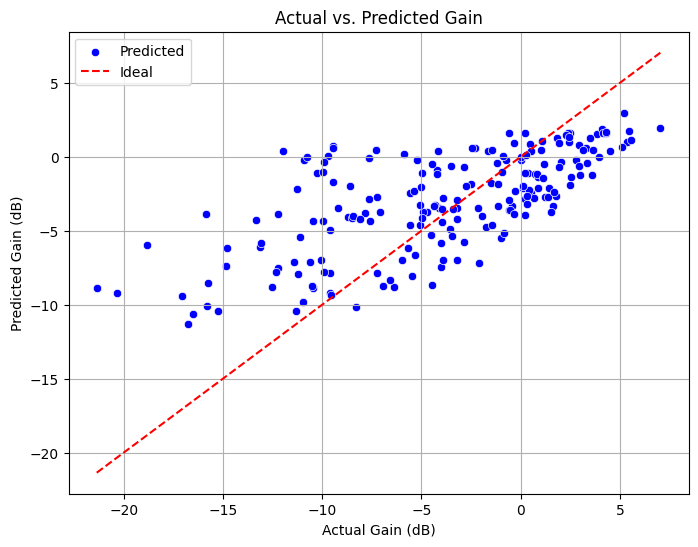

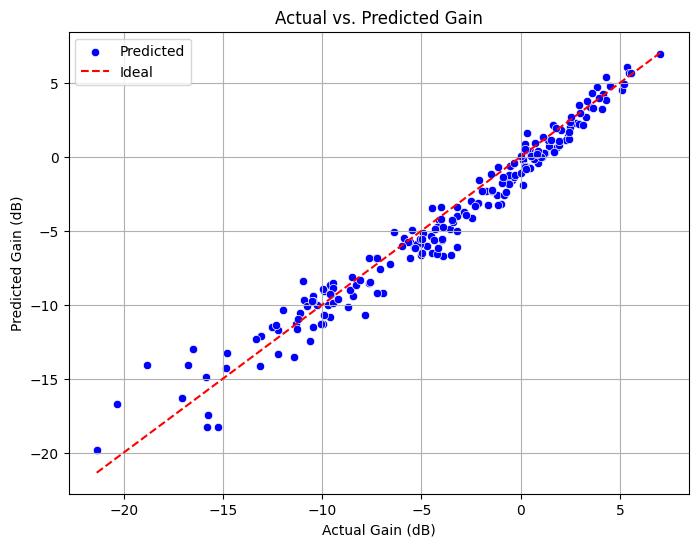

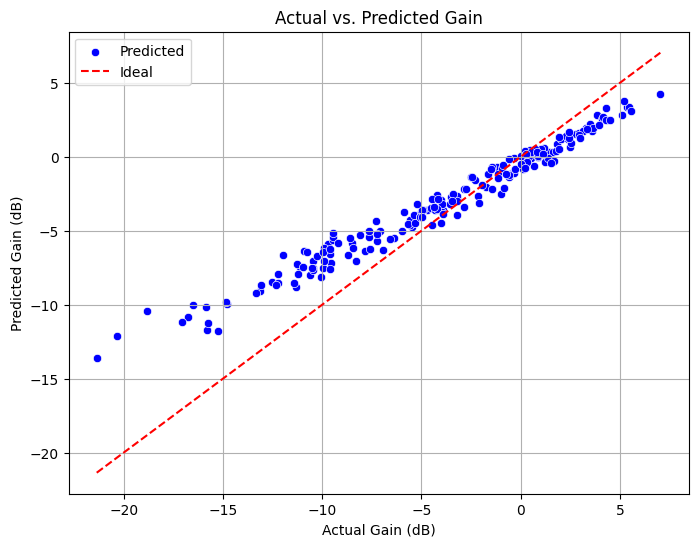

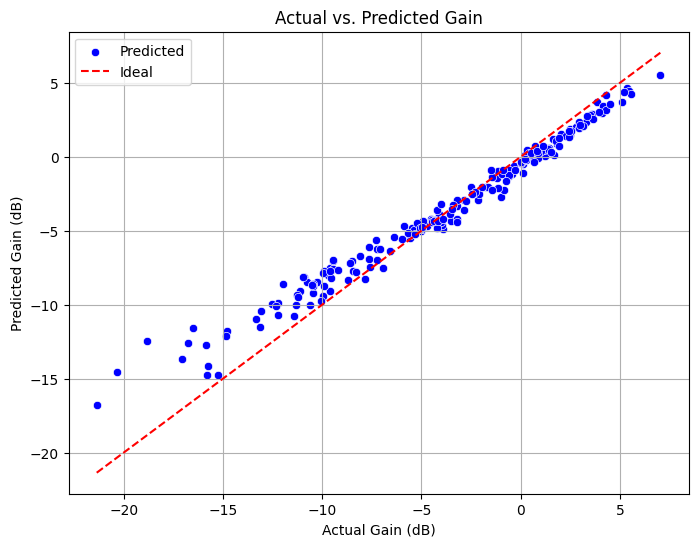

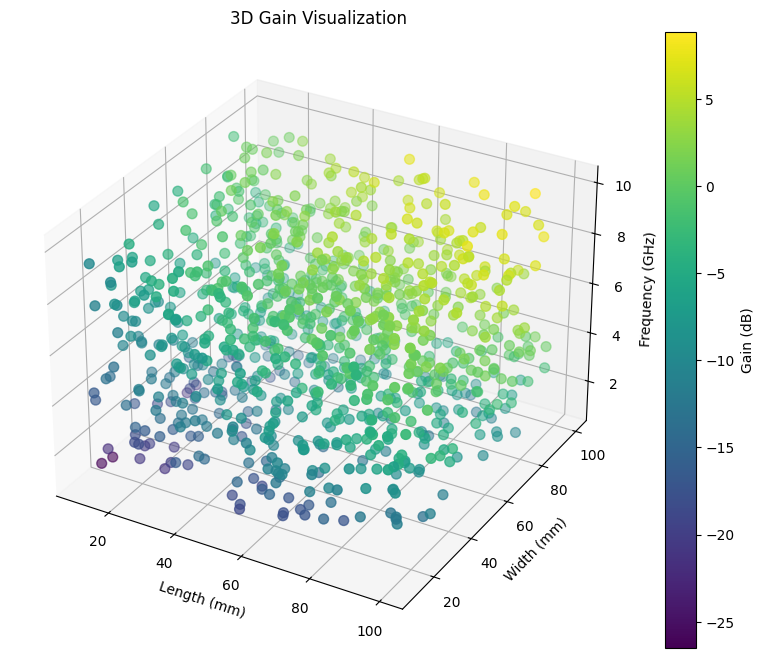

In [15]:
# Call the plot functions
plot_actual_vs_predicted(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred2)
plot_actual_vs_predicted(y_test, y_pred3)
plot_actual_vs_predicted(y_test, y_pred4)
plot_3d_gain(data)

#***Get User Input and Suggest Improvements***


Enter your antenna parameters:
Length (mm): 45
Width (mm): 50
Height (mm): 10
Frequency (GHz): 3.5
Substrate Material (FR4/PTFE/Ceramic): ceramic
Feed Position (Center/Edge): center
Bandwidth (MHz): 5
Directivity (dB): 10.0


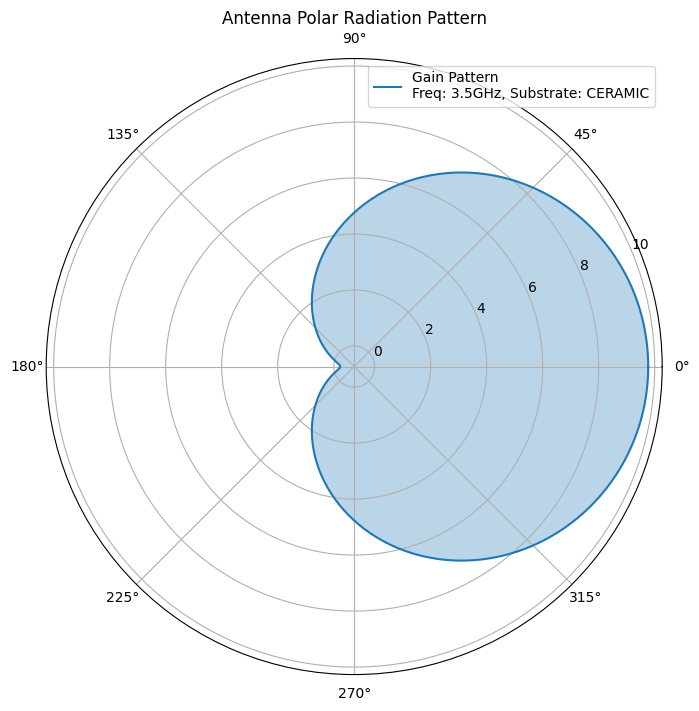

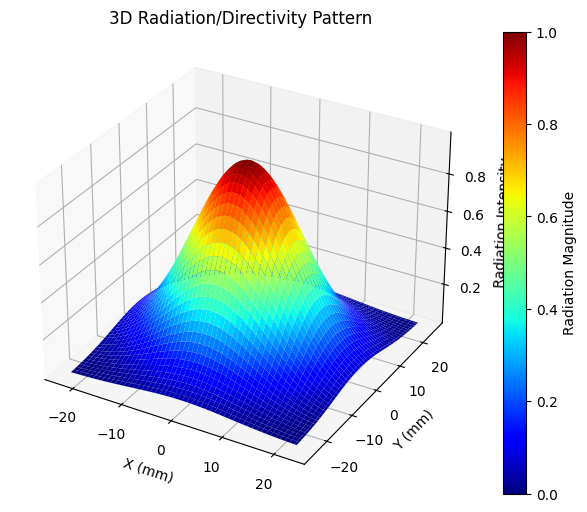




Predicted Gain for the given parameters: -3.48 dB




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### **_Suggestions to improve GAIN:_**

### **- Increase the length and width to maximize effective area.**

### **- Increase the operating frequency for better performance.**

In [16]:
# Example usage
length, width, height, frequency, substrate, feed_position, bandwidth, directivity = get_user_input()
plot_polar_gain(length, width, frequency, substrate, feed_position, bandwidth, directivity)
plot_3d_colormap(length, width, frequency, height)
suggest_improvements(length, width, height, frequency, substrate, feed_position, bandwidth, directivity, model)